In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from R125_bmimPF6_PR import configuration
data = pd.read_csv('R125IL.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [3]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.5)

# m.fs.properties.PR_kappa_A['bmimPF6', 'R125'].fix(-1.195988)
# m.fs.properties.PR_kappa_A['R125', 'bmimPF6'].fix(-0.08814)
# m.fs.properties.PR_kappa_B['bmimPF6', 'R125'].fix(1.56874)
# m.fs.properties.PR_kappa_B['R125', 'bmimPF6'].fix(0.08489)

# m.fs.properties.PR_kappa_A['bmimPF6', 'R125'].fix(0.28636)
# m.fs.properties.PR_kappa_A['R125', 'bmimPF6'].fix(-0.00356)
# m.fs.properties.PR_kappa_B['bmimPF6', 'R125'].fix(0.0)
# m.fs.properties.PR_kappa_B['R125', 'bmimPF6'].fix(0.0)

m.fs.properties.PR_kappa_A['bmimPF6', 'R125'].fix(1.4)
m.fs.properties.PR_kappa_A['R125', 'bmimPF6'].fix(0.0)
m.fs.properties.PR_kappa_B['bmimPF6', 'R125'].fix(0.0)
m.fs.properties.PR_kappa_B['R125', 'bmimPF6'].fix(0.0)

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].unfix()

R125_x = np.zeros((len(data)))
P = np.zeros((len(data)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"] == m.fs.liq)

for i in range(len(data)):
    m.fs.liq = data["x_bmimPF6"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(float(data["x_R125"].iloc[i])+0.05)
    m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].fix(float(1-(data["x_R125"].iloc[i]+0.05)))
    m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))
    
    print("x =", data["x_bmimPF6"].iloc[i])
    
    try:
        
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R125_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')

    except ValueError:

        R125_x[i] = 'NaN'
        P[i] = 'NaN'

x = 0.987
x = 0.966
x = 0.925
x = 0.874
x = 0.815
x = 0.745
x = 0.658
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
Infeasible.
x = 0.538
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
Infeasible.
x = 0.977
x = 0.95
x = 0.92
x = 0.889
x = 0.857
x = 0.82
x = 0.739
x = 0.637
x = 0.987
x = 0.972
x = 0.958
x = 0.943
x = 0.928
x = 0.913
x = 0.88
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
Infeasible.
x = 0.846
x = 0.993
x = 0.984
x = 0.975
x = 0.967
x = 0.957
x = 0.947
x = 0.93
x = 0.912


In [4]:
print(P)
print(data["pressure"])
print(R125_x)
print(data["x_R125"])

[   34143.55215598    84515.90708342   165716.55797824               nan
   281130.38269613   978974.83446935        0.                0.
    86842.25647708   176507.29663245   259973.69600399   330809.75711415
               nan               nan  1190443.31854419 14271202.56833437
    86081.43420292   180339.24094686   263794.1965729    346560.23293202
   424855.11758067   495413.19438824        0.           740369.93936849
    72529.35053292   164114.39541701   253742.82361905   330682.60736673
   424679.72884373   515581.6747357    663814.9670726    807743.80337436]
0       9900
1      99600
2     199600
3     299600
4     399600
5     499700
6     599700
7     699600
8      99600
9     199800
10    299500
11    399800
12    499500
13    599500
14    799600
15    999800
16     99600
17    199800
18    300000
19    399700
20    499900
21    599600
22    799700
23    999600
24     99700
25    199600
26    299700
27    399700
28    499800
29    599800
30    800000
31    999600
Name: p

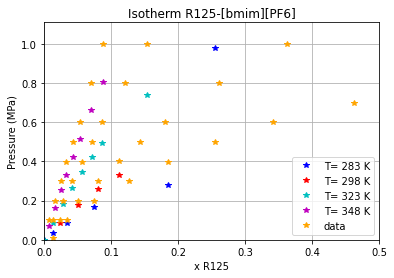

In [5]:
# for i in range(len(P)):
#     P[i] = P[i]*1e6
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

    
plt.plot(R125_x[0:8],P1[0:8],"b*",label="T= 283 K")  
plt.plot(R125_x[8:16],P1[8:16],"r*",label="T= 298 K") 
plt.plot(R125_x[16:24],P1[16:24],"c*",label="T= 323 K") 
plt.plot(R125_x[24:],P1[24:],"m*",label="T= 348 K")
plt.plot(data["x_R125"],data["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R125-[bmim][PF6]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R125')
plt.grid(True)
plt.ylim(0,1.110000)
plt.xlim(0,0.5)
plt.legend()
plt.show()

In [6]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value       : Fixed : Bounds
          Heat Duty :     -476.71 : False : (None, None)
    Pressure Change : -1.9186e+05 : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                              Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                   1.0000     0.054825       0.94518  
    mole_frac_comp bmimPF6    0.86200   1.0000e-08       0.91200  
    mole_frac_comp R125       0.13800       1.0000      0.088000  
    temperature                348.20       348.20        348.20  
    pressure               9.9960e+05   8.0774e+05    8.0774e+05  


In [7]:
# print(P1)

In [8]:
df = pd.DataFrame(P)
# df.to_csv('P_cons_125.csv')
# df.to_csv('P_lin_125.csv')
# df.to_csv('P_ter_125.csv')

In [9]:
m.display()

Model unknown

  Variables:
    None

  Objectives:
    None

  Constraints:
    None

  Blocks:
    Block fs
    
      Variables:
        None
    
      Objectives:
        None
    
      Constraints:
        liquid : Size=1
            Key  : Lower : Body  : Upper
            None : 0.912 : 0.912 : 0.912
    
      Blocks:
        Block fs.properties
        
          Variables:
            PR_kappa_A : PRA binary interaction parameters
                Size=4, Index=fs.properties.PR_kappa_A_index
                Key                    : Lower : Value : Upper : Fixed : Stale : Domain
                      ('R125', 'R125') :  None :   0.0 :  None :  True :  True :  Reals
                   ('R125', 'bmimPF6') :  None :   0.0 :  None :  True :  True :  Reals
                   ('bmimPF6', 'R125') :  None :   1.4 :  None :  True :  True :  Reals
                ('bmimPF6', 'bmimPF6') :  None :   0.0 :  None :  True :  True :  Reals
            PR_kappa_B : PRB binary interaction para